In [1]:
import pandas as pd
import numpy as np
from  statsmodels.tsa.api import SimpleExpSmoothing, Holt
import matplotlib.pyplot as plt
import datetime
from sklearn.metrics import mean_squared_error

import warnings

from statsmodels.tools.sm_exceptions import ConvergenceWarning, ModelWarning
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter('ignore', ModelWarning)

# IBM HOLT TEST

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1962-02-01,6.978967,7.087317,6.978967,7.068196,1.577106,674670
1962-02-02,7.068196,7.112811,7.036329,7.112811,1.587062,533460
1962-02-05,7.112811,7.112811,6.985341,7.023582,1.567152,329490
1962-02-06,7.023582,7.036329,6.998088,7.029955,1.568787,274575
1962-02-07,7.036329,7.074570,7.036329,7.036329,1.570211,266730
...,...,...,...,...,...,...
1965-12-06,8.070427,8.102294,7.934990,7.998725,1.791781,1041816
1965-12-07,8.026609,8.142129,8.026609,8.102294,1.814982,407940
1965-12-08,8.134162,8.205864,8.134162,8.150096,1.825689,395388


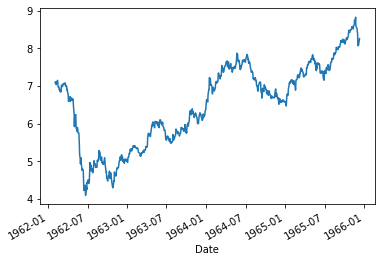

In [5]:
ibm = pd.read_csv('../Lab2/IBM.csv', index_col=['Date'])
ibm.index=pd.to_datetime(ibm.index, format='%d/%m/%Y')
freq = pd.infer_freq(ibm.index)
ibm['High'].plot()
#
ibm

1963-01-01 00:00:00


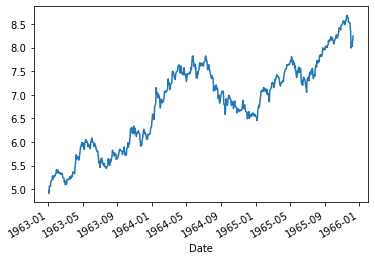

In [6]:
# take the linear part
timestart = datetime.datetime(1963,1,1)
timeend = datetime.datetime(1966,1,1)
print((timestart))
ibm_linear = ibm.loc['1963-01-02':'1966-01-01']
ibm_linear['Open'].plot()

params = [
    "smoothing_level",
    "smoothing_trend",
    "damping_trend",
    "initial_level",
    "initial_trend",
]

Holt's try to find    0.95
Holt's estimated      1.00
Name: $\alpha$, dtype: float64 Holt's try to find    5.000000e-02
Holt's estimated      1.175507e-13
Name: $\beta$, dtype: float64


C:\Users\maxgr\AppData\Local\Temp/ipykernel_19276/826320012.py:58: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = ax[1].pcolormesh(x, y, np.array(mses).reshape((param_num, param_num)), cmap='RdBu', vmin=np.min(mses), vmax=np.max(mses))


,Holt's try to find,Holt's estimated
$\alpha$,0.950000,1.000000e+00
$\beta$,0.050000,1.175507e-13
$\phi$,NaN,NaN
$l_0$,4.911196,4.968435e+00
$b_0$,1.007098,1.000580e+00


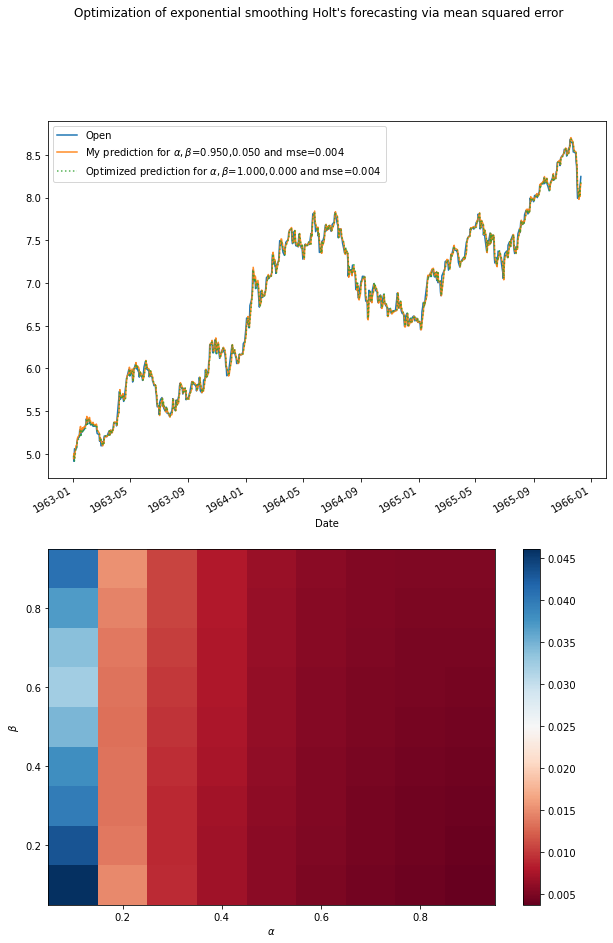

In [28]:
fig, ax = plt.subplots(2, figsize = (10,16))
plt.suptitle("Optimization of exponential smoothing Holt's forecasting via mean squared error")
col = 'Open'
numpy_df = ibm_linear[col].to_numpy()
#print(numpy_df)
best_mse = 1e18

bestFit = None
start = 0.05
end = 1.0
step = 0.1
param_num =int((end - start)/step) + 1
alphas = np.arange(start, end, step)
betas = np.arange(start, end, step)

mses = []

y, x = np.meshgrid(alphas, betas)
# sweep through all alphas
for alpha in alphas:
    for beta in betas:
        fit = Holt(numpy_df, exponential=True,
                   initialization_method="estimated").fit(smoothing_level=alpha, smoothing_trend=beta, optimized = False)
        fitted = fit.fittedvalues
        mse = mean_squared_error(fitted, numpy_df)
        
        mses.append(mse)
        #print(r"For $\alpha =$"+ f"{alpha:.3f}" "and $\beta =$"+ f"{beta:.3f} the mse is {mse:.3f}")    
        if mse < best_mse: 
            best_mse = mse
            bestFit = fit   
            
        
# make optimized prediction from the library
fit = Holt(ibm_linear[col], exponential=True, initialization_method="estimated",).fit()  
m=mean_squared_error(np.array(fit.fittedvalues), numpy_df)


# plot the results 
results = pd.DataFrame(
    index=[r"$\alpha$", r"$\beta$", r"$\phi$", r"$l_0$", "$b_0$"],
    columns=["Holt's try to find", "Holt's estimated"],
)

results["Holt's try to find"] = [bestFit.params[p] for p in params] 
results["Holt's estimated"] = [fit.params[p] for p in params] 
alphas = results.iloc[0]
betas = results.iloc[1]
print(alphas,betas)
# plot 
#ax[0].plot(ibm_linear.index, numpy_df, label = 'original data')
ibm_linear[col].plot(ax=ax[0])
ax[0].plot(ibm_linear[col].index, bestFit.fittedvalues, '-', alpha=0.9,
           label = r'My prediction for $\alpha,\beta$=' + f'{alphas[0]:.3f},{betas[0]:.3f} and mse={best_mse:.3f}')
ax[0].plot(ibm_linear[col].index, fit.fittedvalues, ':', alpha=0.8, label = r'Optimized prediction for $\alpha,\beta$=' + f'{alphas[-1]:.3f},{betas[-1]:.3f} and mse={m:.3f}')
ax[0].legend()

c = ax[1].pcolormesh(x, y, np.array(mses).reshape((param_num, param_num)), cmap='RdBu', vmin=np.min(mses), vmax=np.max(mses))
fig.colorbar(c, ax = ax[1])
#ax[1].plot(alphas, mses_stat, label = 'from statsmodel')
#ax[1].plot(alphas, mses_mine, label = 'from mymodel')
ax[1].set_xlabel(r"$\alpha$")
ax[1].set_ylabel(r"$\beta$")
#ax[1].set_title(r"Model parameter $\alpha$ optimization")
results